In [2]:
# Import libraries necessary for this project

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
    
import numpy as np
import pandas as pd
import os
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.layers import Embedding,Dense,GlobalMaxPool1D,Dropout,Flatten,Bidirectional,LSTM
from keras.models import Sequential
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#import nltk
#from nltk import Text
#from nltk.tokenize import regexp_tokenize
#from nltk.tokenize import word_tokenize  
#from nltk.tokenize import sent_tokenize 
#from nltk.corpus import stopwords
#from nltk.stem import WordNetLemmatizer
#from nltk import pos_tag
#from collections import Counter

#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

In [3]:
df = pd.read_json('/home/jovyan/data/train.jsonl', lines=True)
df_dev = pd.read_json('/home/jovyan/data/dev.jsonl', lines=True)
df_test_f = pd.read_json('/home/jovyan/data/test.jsonl', lines=True)
df = df[["label","text"]]
df_dev = df_dev[["label","text"]]
df = pd.concat([df, df_dev], ignore_index=True)
df[df.label == 1].head(2)

,label,text
10,1,jew mad? get fuhrerious!
12,1,brother... a day without a blast is a day wasted


In [4]:
print(" #1. checking null data")
df.isnull().sum().sort_values(ascending=False)
df_dev.isnull().sum().sort_values(ascending=False)
df_test_f.isnull().sum().sort_values(ascending=False)

 #1. checking null data


text     0
label    0
dtype: int64

text     0
label    0
dtype: int64

text    0
img     0
id      0
dtype: int64

In [5]:
print(" #2. checking null data")
display(df.label.value_counts())
display(df_dev.label.value_counts())

 #2. checking null data


0    5700
1    3300
Name: label, dtype: int64

1    250
0    250
Name: label, dtype: int64

In [6]:
lens = df.text.str.len()
lens_dev = df_dev.text.str.len()
lens_test_f = df_test_f.text.str.len()
lens.mean(), lens.std(), lens.max()
lens_dev.mean(), lens_dev.std(), lens_dev.max()
lens_test_f.mean(), lens_test_f.std(), lens_test_f.max()

(61.64322222222222, 36.76952449528946, 433)

(54.29, 31.0318522119355, 207)

(55.468, 32.174993491937286, 382)

In [7]:
x = df["text"]
y = df["label"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

In [8]:
df.count()
x_train.count()
x_test.count()

label    9000
text     9000
dtype: int64

8100

900

In [9]:
words = (df.text.str.count(' ')  + df.text.str.count('\n'))
words.mean(), words.std(), words.max()

(10.664444444444445, 6.836644416745101, 69)

In [77]:

def digin(meme_comnts, memeType):
    t_tokenized_sents = [word_tokenize(sentences) for sentences in meme_comnts] # create sentences
    t_tagged = [pos_tag(words) for words in t_tokenized_sents]                   # create tags for each token

    t_categories = [y for lists in t_tagged for x,y in lists]                    # extract tags
    t_counting_catg = Counter(t_categories) 

    df_pos = pd.DataFrame.from_dict(t_counting_catg, orient='index').reset_index()
    df_pos.columns=('category','amount')
    df_pos = df_pos.sort_values(by='amount', ascending=False)
    df_pos = df_pos[:15]                                                                 # limit to the top 15 highest counts of taggs
    df_pos['%'] = df_pos['amount']/ df_pos['amount'].sum(axis=0)                             # calculate percentage

    sns.barplot(x='category', y='%', data=df_pos)            
    plt.title("% of the time POS appears in " + memeType + " memes")
    fig=plt.gcf()
    fig.set_size_inches(10,5)
    plt.show()

In [11]:
#hateful_meme_comnts = df[df.label==0]['text']
#non_hateful_meme_comnts = df[df.label==1]['text']
#digin(hateful_meme_comnts, "hateful")
#digin(non_hateful_meme_comnts, "non_hateful")

In [12]:
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(x)
xtrain= tokenizer.texts_to_sequences(x_train)
xtest= tokenizer.texts_to_sequences(x_test) 
vocab_size=len(tokenizer.word_index)+1

In [13]:
print(vocab_size)

9326


In [15]:
maxlen=100
xtrain=pad_sequences(xtrain,padding='post', maxlen=maxlen)
xtest=pad_sequences(xtest,padding='post', maxlen=maxlen)

print(x_train[3])
print(xtrain[3])

i love everything and everybody! except for squirrels i hate squirrels
[  65  230   65  132    6    1  239 1314    6  297  143 1021    9    1
 1497    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [16]:
embedding_dim=50
model=Sequential([Embedding(input_dim=vocab_size,output_dim=embedding_dim,input_length=maxlen),
                 Bidirectional(LSTM(32,return_sequences=True)),
                 GlobalMaxPool1D(),
                 Dense(32,activation='relu'),
                 Dropout(0.5),
                 Dense(1,activation='sigmoid')
                 ])

model.compile(optimizer='adam',loss='binary_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           466300    
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 64)           21248     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 489,661
Trainable params: 489,661
Non-trainable params: 0
__________________________________________________

In [18]:
history = model.fit(xtrain, y_train, epochs=1, batch_size=10, validation_split=.25, steps_per_epoch=300)


300/300 [==============================] - 54s 181ms/step - loss: 0.6299 - accuracy: 0.6597 - val_loss: 0.6097 - val_accuracy: 0.6889


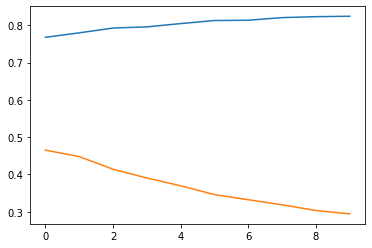

In [103]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

In [19]:
y_pred = model.predict(xtest).ravel()

In [20]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

0.6749077222959522


<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'False positive rate')

Text(0, 0.5, 'True positive rate')

Text(0.5, 1.0, 'ROC curve')

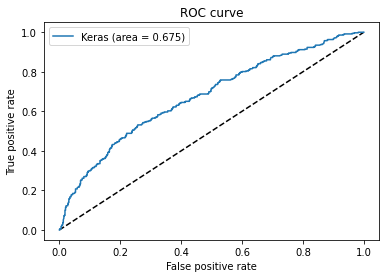

In [21]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [22]:
# validation data
x_dev = df_dev["text"]
y_dev = df_dev["label"]

#tokenizer.fit_on_texts(x_dev)
xdev= tokenizer.texts_to_sequences(x_dev)

maxlen=10
xdev=pad_sequences(xdev,padding='post', maxlen=maxlen)

print(x_dev[3])
print(xdev[3])

it is time.. to send these parasites back to the desert
[ 14   8  62   4 416 124  86   4   1   0]


In [23]:
y_dev_pred = model.predict(xdev).ravel()
fpr_dev_keras, tpr_dev_keras, thresholds_dev_keras = roc_curve(y_dev, y_dev_pred)
auc_dev_keras = auc(fpr_dev_keras, tpr_dev_keras)
#print(y_dev_pred)

In [24]:
# final test data
xtest_f = df_test_f["text"]

#tokenizer.fit_on_texts(xtest_f)
xtestf= tokenizer.texts_to_sequences(xtest_f)

maxlen=10
xtestf=pad_sequences(xtestf,padding='post', maxlen=maxlen)

print(xtest_f[3])
print(xtestf[3])

y_test_f_pred = model.predict(xtestf).ravel()

laughs in [majority of u.s crime rate]
[1482    9   10  237  579  447 1483    0    0    0]


In [26]:
df_to_submit = df_test_f[["id"]]
df_to_submit["proba"] = y_test_f_pred
df_to_submit["label"] = df_to_submit['proba'].map(lambda x: 1 if x > 0.5 else 0)
df_to_submit.head()

#print(df_test_f[df_test_f.label == 1])
df_to_submit.to_csv('/home/jovyan/data/csv_to_submit' + datetime.now().strftime("%Y%m%d-%H%M%S") +'.csv', index = False)


<ipython-input-26-7dbf453e7110>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_submit["proba"] = y_test_f_pred


,id,proba,label
0,16395,0.334542,0
1,37405,0.498891,0
2,94180,0.497535,0
3,54321,0.353882,0
4,97015,0.582826,1
